In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from tensorflow import keras

## (建立時間序列資料)

In [2]:
# 時間序列資料的生成
def generate_time_series (m, n_seq): #----->m個樣本,n_seq長度的時間序列
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, m, 1) #----->4組 m*1個隨機數(0-1小數)
    time = np.linspace(0, 1, n_seq) #----->0-1，切成 n_seq
    #series => m*n_seq 二維 
    series = 0.5* np.cos((time - offsets1)*(freq1 * 10 +10))
    series += 0.3* np.sin((time - offsets2)*(freq2* 20+20))
    series += 0.1 * (np. random. rand(m, n_seq) - 0.5) #----->二維：m * n_seq 
    return series [..., np.newaxis].astype(np.float32) #----->對全部資料增加第三維度並轉成小數


In [3]:
np. random. seed (1)
n_seq = 30
n_pred = 1 #----->預測新的幾步

series = generate_time_series(5000, n_seq + n_pred) #----->建立 5000筆
series.shape

(5000, 31, 1)

In [7]:
x_train, y_train = series[:3000, :n_seq], series[:3000, -1] #----->不包含最後一筆
x_valid, y_valid = series[3000:4000, :n_seq], series[3000:4000, -1]
x_test, y_test = series[4000:, :n_seq], series[4000:, -1]


In [5]:
x_train.shape, y_train.shape

((3000, 30, 1), (3000, 1))

In [8]:
def plot_seq(x, y, y_pred=None):
    plt.plot(x,'.-')
    n_seq = x.shape[0]#第一維是0，其shape=(30,1),shape[0]=30
    ahead = y.shape[0]#shape[0]=1
    #繪製 y 點位置
    plt.plot(np.arange(n_seq, n_seq + ahead), y, 'go-', label='$y$') 
    
    if y_pred is not None:#如果有預測值會另繪一條線
        plt.plot(np. arange (n_seq, n_seq + ahead), y_pred, 'rx-',
                 label='$\hat y$', markersize=10)
    plt.hlines (0, 0, n_seq + ahead, linewidth=1) #水平線
    plt.axis([0, n_seq + ahead, -1, 1]) #指定X軸與Y軸的刻度範圍
    plt.grid(True)
    plt.legend (fontsize=14)

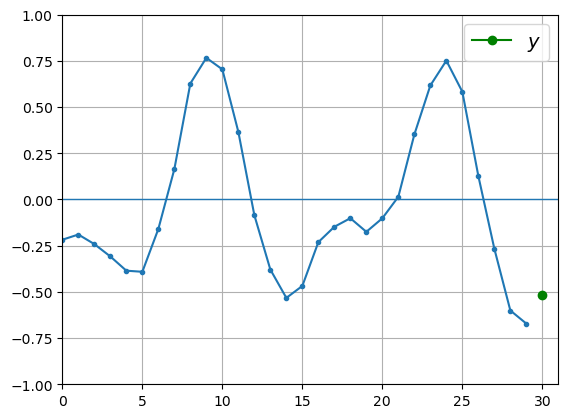

In [9]:
plot_seq(x_test[0, :, 0], y_test[0])#傳入第一筆資料


# (SimpleRNN : 1層)

In [10]:
np. random. seed (1)
tf.random.set_seed(1)

In [11]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1]) #----->預設activation='tanh'(-1～1)
])
model. summary ()
'''
Param ＝ (1b+1Wx輸入權重+1Wh輸出權重)*1傳回神經元 ＝ 3
'''

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 3         
                                                                 
Total params: 3 (12.00 Byte)
Trainable params: 3 (12.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


'\nParam ＝ (1b+1Wx輸入權重+1Wh輸出權重)*1傳回神經元 ＝ 3\n'

In [12]:
opt = keras.optimizers.Adam(learning_rate=0.05)

model.compile(loss='mse', optimizer=opt) #----->因為 y 是連續型的數值，所以適用 mse

In [13]:
train = model.fit (x_train, y_train, epochs=20, 
                   validation_data=(x_valid, y_valid))

Epoch 1/20
94/94 [==============================] - 2s 6ms/step - loss: 0.0305 - val_loss: 0.0294
Epoch 2/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0302 - val_loss: 0.0286
Epoch 3/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0303 - val_loss: 0.0292
Epoch 4/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0304 - val_loss: 0.0288
Epoch 5/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0301 - val_loss: 0.0287
Epoch 6/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0302 - val_loss: 0.0286
Epoch 7/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0302 - val_loss: 0.0286
Epoch 8/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0303 - val_loss: 0.0286
Epoch 9/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0300 - val_loss: 0.0284
Epoch 10/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0304 - val_loss: 0.0304
Epoch 11/20
94/94 [

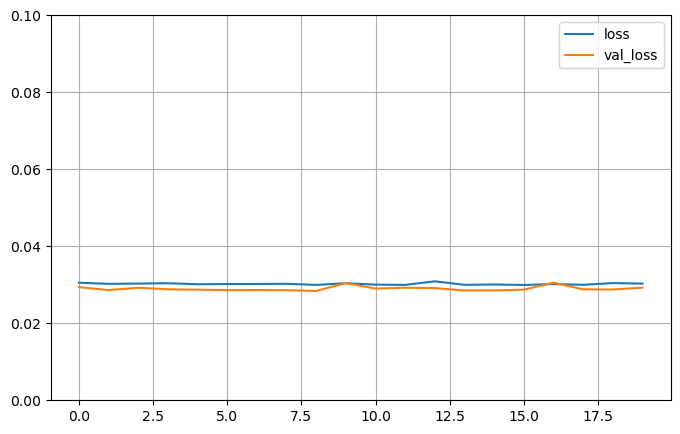

In [14]:
pd. DataFrame (train.history).plot(figsize=(8, 5)) 
plt.grid(True) 
plt.ylim(0, 0.1) 
plt.show()

In [17]:
model. evaluate(x_test, y_test )

32/32 [==============================] - 0s 2ms/step - loss: 0.0310


0.03102295845746994

In [16]:
y_pred = model.predict(x_test)

32/32 [==============================] - 0s 2ms/step


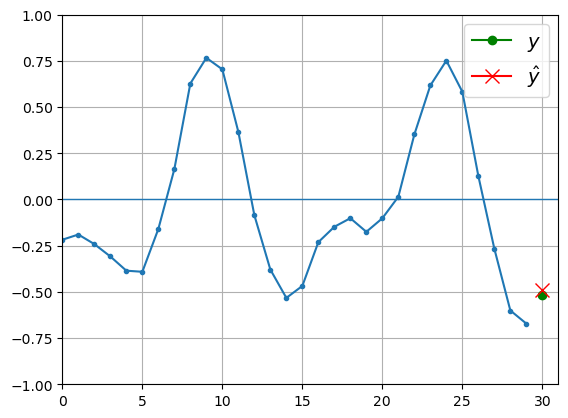

In [18]:
i = 0
plot_seq(x_test[i, :, 0], y_test[i], y_pred[i])
# 加上預測值后，觀察綠點(y)和紅點(y_hat)的差異

# (Deep RNN) : 3層

In [19]:
# Deep RNN
# 1. Build Model
np. random. seed (1)
tf. random. set_seed (1)

In [20]:
model = keras. models. Sequential([
    #前二層各有同數量20個神經元 
    #當下一層也是RNN層時，要加上return_sequences=True，才能回傳(預設是False)
    #因為要記錄 y 序列送到下一層
    keras. layers. SimpleRNN(20, return_sequences=True, input_shape=[None, 1]), 
    keras. layers. SimpleRNN(20, return_sequences=True), 
    keras. layers. SimpleRNN(1)
])

In [21]:
model.summary()
'''
simple_rnn_1:440=(1 bias+1 feature+20個傳回的y)*20個神經元
simple_rnn_2:820=(1 bias+20 feature+20個傳回的y)*20個神經元
simple_rnn_3: 22=(1 bias+20 feature+1個傳回的y)*1個神經元 
'''

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 1)                 22        
                                                                 
Total params: 1282 (5.01 KB)
Trainable params: 1282 (5.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


'\nsimple_rnn_1:440=(1 bias+1 feature+20個傳回的y)*20個神經元\nsimple_rnn_2:820=(1 bias+20 feature+20個傳回的y)*20個神經元\nsimple_rnn_3: 22=(1 bias+20 feature+1個傳回的y)*1個神經元 \n'

In [22]:
# 2. Compile
model.compile(loss='mse', optimizer='adam')

In [23]:
# 3. Train
train = model.fit(x_train, y_train, epochs=20, 
                  validation_data=(x_valid, y_valid))

Epoch 1/20
94/94 [==============================] - 3s 13ms/step - loss: 0.0803 - val_loss: 0.0327
Epoch 2/20
94/94 [==============================] - 1s 9ms/step - loss: 0.0224 - val_loss: 0.0168
Epoch 3/20
94/94 [==============================] - 1s 10ms/step - loss: 0.0151 - val_loss: 0.0137
Epoch 4/20
94/94 [==============================] - 1s 10ms/step - loss: 0.0120 - val_loss: 0.0108
Epoch 5/20
94/94 [==============================] - 1s 9ms/step - loss: 0.0103 - val_loss: 0.0095
Epoch 6/20
94/94 [==============================] - 1s 9ms/step - loss: 0.0095 - val_loss: 0.0082
Epoch 7/20
94/94 [==============================] - 1s 10ms/step - loss: 0.0086 - val_loss: 0.0082
Epoch 8/20
94/94 [==============================] - 1s 9ms/step - loss: 0.0083 - val_loss: 0.0095
Epoch 9/20
94/94 [==============================] - 1s 9ms/step - loss: 0.0078 - val_loss: 0.0068
Epoch 10/20
94/94 [==============================] - 1s 9ms/step - loss: 0.0072 - val_loss: 0.0073
Epoch 11/20
94/

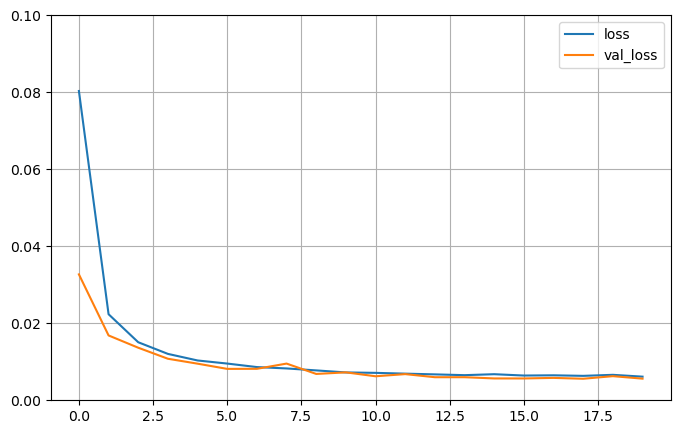

In [24]:
pd.DataFrame(train.history).plot(figsize=(8, 5)) 
plt.grid(True) 
plt.ylim(0, 0.1) 
plt.show()

In [25]:
# 4. Evaluate
model.evaluate(x_test, y_test)

32/32 [==============================] - 0s 3ms/step - loss: 0.0064


0.006439111195504665

In [26]:
# 5. Predict
y_pred = model.predict(x_test)

32/32 [==============================] - 0s 3ms/step


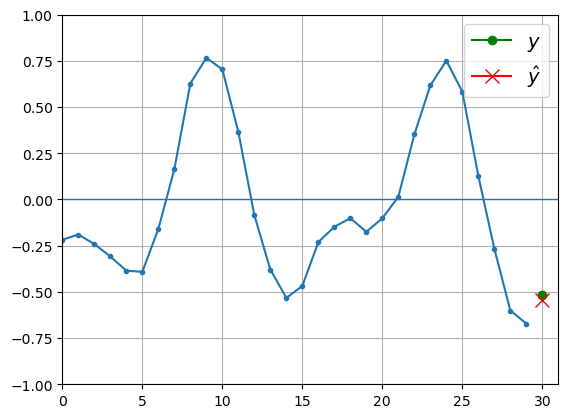

In [28]:
i = 0
plot_seq(x_test[i, :, 0], y_test[i], y_pred[i])

### Deep RNN (dense output layer)

In [26]:
# 1. Build Model
np.random.seed (1)
tf.random.set_seed (1)

In [27]:
model = keras.models.Sequential([
    keras. layers. SimpleRNN(20, return_sequences=True, input_shape= [None, 1]), 
    keras. layers. SimpleRNN(20), 
    keras. layers. Dense(1)
])

In [28]:
model.summary()
'''
simple_rnn_4 (SimpleRNN)  440=(1+1+20)*20   
 simple_rnn_5 (SimpleRNN)  820= (1+20+20)*20 
 dense (Dense)  21 = (1+20)*1
'''

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1281 (5.00 KB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


'\nsimple_rnn_4 (SimpleRNN)  440=(1+1+20)*20   \n simple_rnn_5 (SimpleRNN)  820= (1+20+20)*20 \n dense (Dense)  21 = (1+20)*1\n'

In [29]:
# 2. Compile
model. compile (loss='mse', optimizer='adam')

In [30]:
# 3. Train
train = model. fit(x_train, y_train, epochs=20, 
                   validation_data=(x_valid, y_valid))

Epoch 1/20
94/94 [==============================] - 3s 12ms/step - loss: 0.1437 - val_loss: 0.0328
Epoch 2/20
94/94 [==============================] - 1s 8ms/step - loss: 0.0227 - val_loss: 0.0169
Epoch 3/20
94/94 [==============================] - 1s 8ms/step - loss: 0.0140 - val_loss: 0.0116
Epoch 4/20
94/94 [==============================] - 1s 8ms/step - loss: 0.0105 - val_loss: 0.0094
Epoch 5/20
94/94 [==============================] - 1s 8ms/step - loss: 0.0090 - val_loss: 0.0087
Epoch 6/20
94/94 [==============================] - 1s 8ms/step - loss: 0.0081 - val_loss: 0.0079
Epoch 7/20
94/94 [==============================] - 1s 8ms/step - loss: 0.0075 - val_loss: 0.0068
Epoch 8/20
94/94 [==============================] - 1s 9ms/step - loss: 0.0070 - val_loss: 0.0064
Epoch 9/20
94/94 [==============================] - 1s 8ms/step - loss: 0.0068 - val_loss: 0.0064
Epoch 10/20
94/94 [==============================] - 1s 10ms/step - loss: 0.0065 - val_loss: 0.0063
Epoch 11/20
94/94

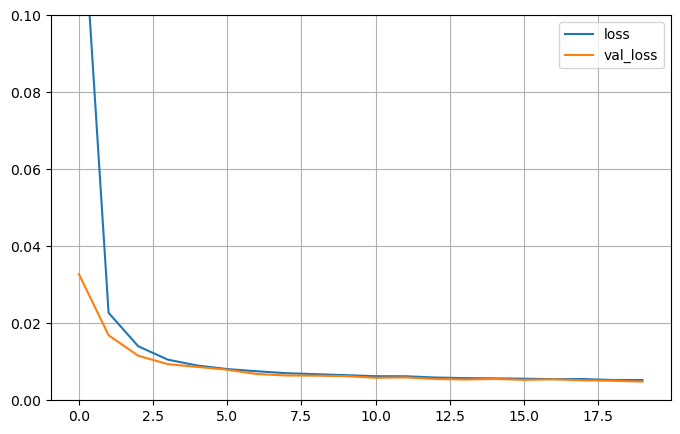

In [31]:
pd.DataFrame(train.history).plot(figsize=(8, 5)) 
plt.grid (True) 
plt.gca().set_ylim(0, 0.1) 
plt.show()

In [32]:
# 4. Evaluate
model.evaluate(x_test, y_test)

32/32 [==============================] - 0s 3ms/step - loss: 0.0052


0.005236451979726553

In [33]:
# 5. Predict
y_pred = model.predict(x_test)

32/32 [==============================] - 0s 3ms/step


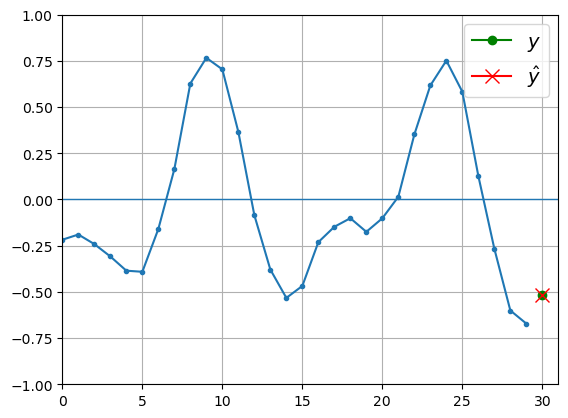

In [34]:
i = 0
plot_seq(x_test[i, :, 0], y_test[i], y_pred[i])